# Exploratory Data Analysis

In [29]:
import pandas as pd
import numpy as np
import altair as alt
from altair_saver import save
import datetime


In [3]:
# alt.data_transformers.enable('json')
# alt.renderers.enable('default')

alt.renderers.enable('mimetype'); # Jupyter Lab 2.x
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

### Load Data

In [4]:
ORD = pd.read_csv('../data/ORD.csv', index_col='Unnamed: 0')
ORD_train = ORD[ORD['year'] < 2018]

In [5]:
ORD_train.head(5)

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline
0,2013,1,1,0,22,24.98,17.96,74.290000,9.000000,0.0,9.000000,14.780000,3.000000,547.597141,3.0
1,2013,1,1,1,9,24.89,17.78,73.995000,9.000000,0.0,8.000000,14.670000,5.000000,148.479860,1.0
2,2013,1,1,2,11,21.20,14.00,73.320000,10.000000,0.0,9.000000,9.420000,5.000000,NaN,NaN
3,2013,1,1,3,3,21.14,12.14,67.723333,10.666667,0.0,9.666667,8.976667,4.333333,NaN,NaN
4,2013,1,1,4,5,19.94,10.94,67.580000,10.000000,0.0,10.000000,7.840000,5.000000,860.523798,4.0


In [6]:
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})

### Add Lagged Data

In [7]:
lag = 3
ORD_train_lag = lag_df(ORD_train, lag=lag, cols=['seats'])
#ORD_train_lag = lag_df(ORD_train, lag=lag, cols=ORD_train.columns.tolist())

In [8]:
ORD_train_lag.head(5)

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline,seats-1,seats-2,seats-3
0,2013,1,1,0,22,24.98,17.96,74.290000,9.000000,0.0,9.000000,14.780000,3.000000,547.597141,3.0,NaN,NaN,NaN
1,2013,1,1,1,9,24.89,17.78,73.995000,9.000000,0.0,8.000000,14.670000,5.000000,148.479860,1.0,547.597141,NaN,NaN
2,2013,1,1,2,11,21.20,14.00,73.320000,10.000000,0.0,9.000000,9.420000,5.000000,NaN,NaN,148.479860,547.597141,NaN
3,2013,1,1,3,3,21.14,12.14,67.723333,10.666667,0.0,9.666667,8.976667,4.333333,NaN,NaN,NaN,148.479860,547.597141
4,2013,1,1,4,5,19.94,10.94,67.580000,10.000000,0.0,10.000000,7.840000,5.000000,860.523798,4.0,NaN,NaN,148.479860


### Correlations

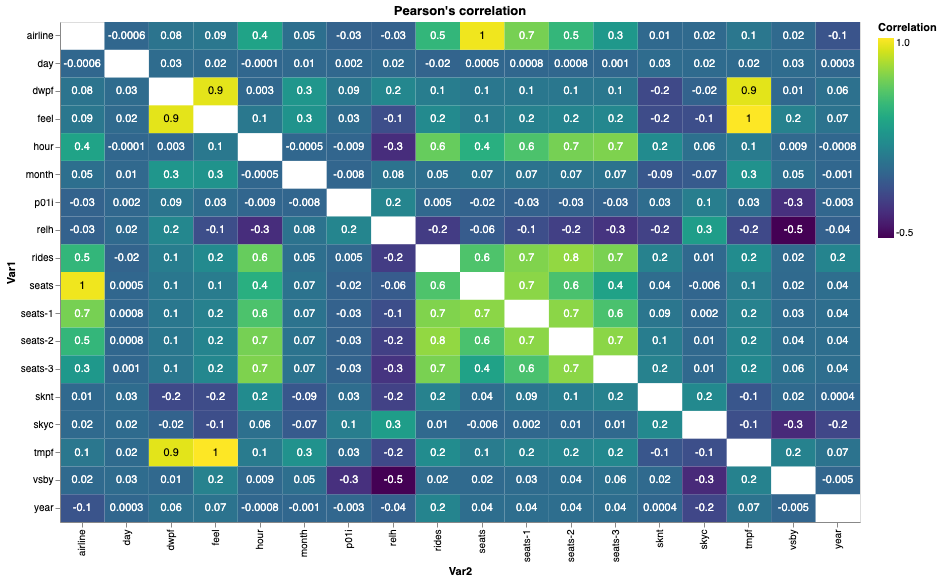

In [9]:
ORD_corr = ORD_train_lag.corr().reset_index().rename(columns = {'index':'Var1'}).melt(id_vars = ['Var1'],
                                                                                    value_name = 'Correlation',
                                                                                    var_name = 'Var2')
ORD_corr = ORD_corr[ORD_corr.Correlation != 1]

base = alt.Chart(ORD_corr).encode(
    alt.Y('Var1:N'),
    alt.X('Var2:N')
) 

heatmap = base.mark_rect().encode(
     alt.Color('Correlation:Q',
                scale=alt.Scale(scheme='viridis'))
)

text = base.mark_text(baseline='middle').encode(
    text=alt.Text('Correlation:Q', format='.1'),
    color=alt.condition(
        alt.datum.Correlation >= 0.90,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).properties(
    width = 800,
    height = 500,
    title = "Pearson's correlation"
)

### Charts

**Hourly seats**

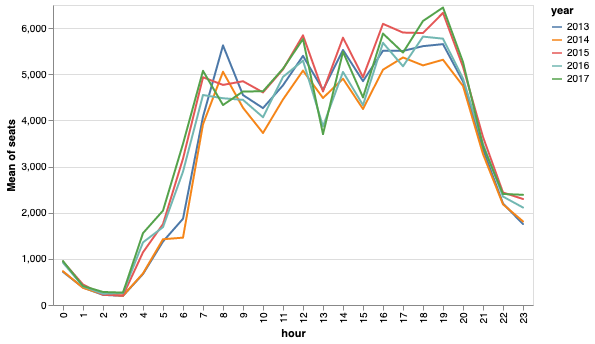

In [10]:
alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('hour:N'),
    y = alt.Y('mean(seats):Q'),
    color = alt.Color('year:N')
)

**Hourly rides**

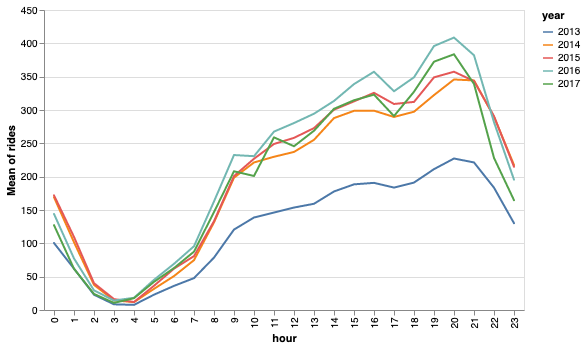

In [11]:
alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('hour:N'),
    y = alt.Y('mean(rides):Q'),
    color = alt.Color('year:N')
)

**Monthly rides**

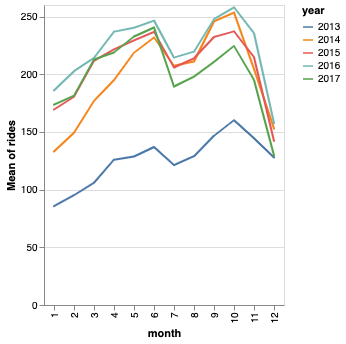

In [12]:
alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('month:N'),
    y = alt.Y('mean(rides):Q'),
    color = alt.Color('year:N')
)

**Monthly seats**

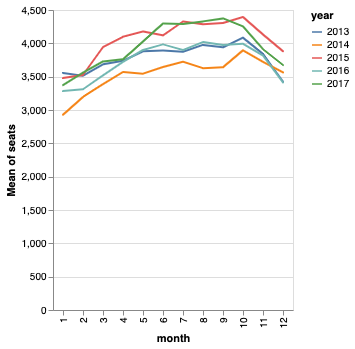

In [17]:
alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('month:N'),
    y = alt.Y('mean(seats):Q'),
    color = alt.Color('year:N')
)

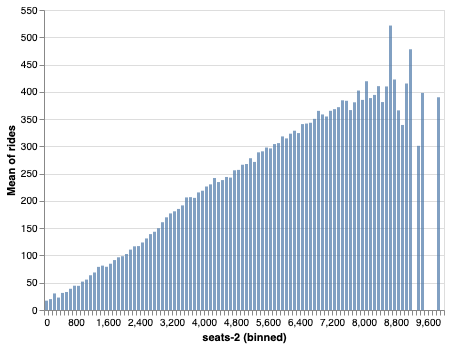

In [13]:
alt.Chart(ORD_train_lag).mark_bar(opacity=0.7).encode(
    x = alt.X('seats-2:Q', bin=alt.Bin(extent=[0, 10000], step=100)),
    y = alt.Y('mean(rides):Q')
)

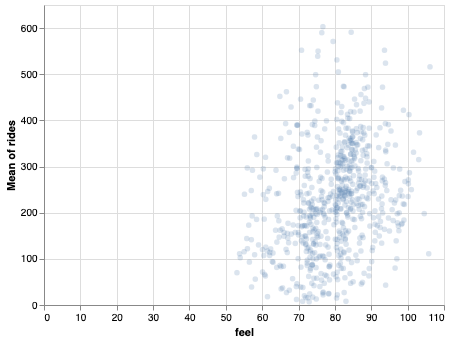

In [14]:
alt.Chart(ORD_train.query('month == 7')).mark_circle(opacity=0.2).encode(
    x = alt.X('feel:Q'),
    y = alt.Y('mean(rides):Q')
)

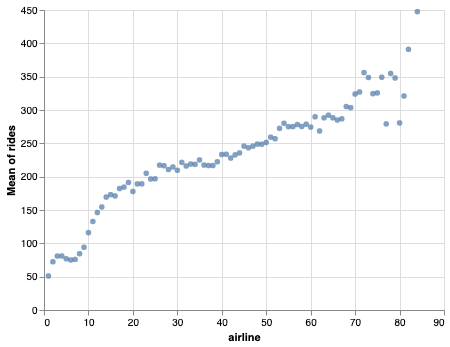

In [15]:
alt.Chart(ORD_train_lag).mark_circle(opacity=0.7).encode(
    x = alt.X('airline:Q'),
    y = alt.Y('mean(rides):Q')
)

In [16]:
alt.__version__

'4.1.0'

In [26]:
daily_ORD_train = ORD_train.groupby(['year','month','day']).sum().reset_index()

In [27]:
daily_ORD_train

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline
0,2013,1,1,276,1466,460.230,175.020000,1449.628333,204.666667,0.000100,235.666667,193.356667,57.333333,77418.063862,757.0
1,2013,1,2,276,1927,417.000,121.710000,1412.280000,152.000000,0.000000,240.000000,195.190000,30.500000,82622.897207,820.0
2,2013,1,3,272,1734,598.480,434.410000,1705.545000,221.500000,0.000800,198.000000,363.475000,98.000000,82918.243422,815.0
3,2013,1,4,276,1566,546.240,351.660000,1722.630000,285.000000,0.000000,239.000000,251.700000,7.000000,83589.268893,822.0
4,2013,1,5,273,1292,675.436,535.180000,1805.362667,171.200000,0.019600,190.133333,502.136000,38.000000,63094.646590,605.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017,12,27,276,3044,26.600,-219.700000,1475.870000,192.224359,0.000067,240.000000,-325.170000,2.769231,86518.508386,660.0
1822,2017,12,28,276,2727,156.075,-57.700000,1597.457500,123.524267,0.027220,203.896978,-68.915833,72.230769,85781.359497,653.0
1823,2017,12,29,276,2522,292.750,145.593333,1827.038333,154.757660,0.047421,145.718197,43.174333,99.457983,85633.542853,652.0
1824,2017,12,30,276,2641,205.250,-23.150000,1561.060000,267.941403,0.021000,197.182692,-171.965000,55.741758,72573.736486,565.0


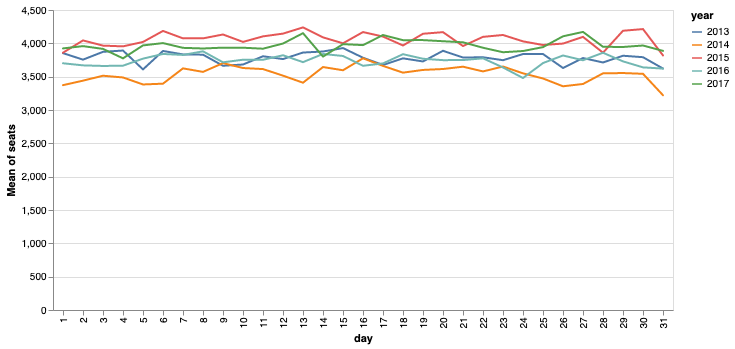

In [25]:
alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('day:N'),
    y = alt.Y('mean(seats):Q'),
    color = alt.Color('year:N')
)

**Taxi rides per day of the week**

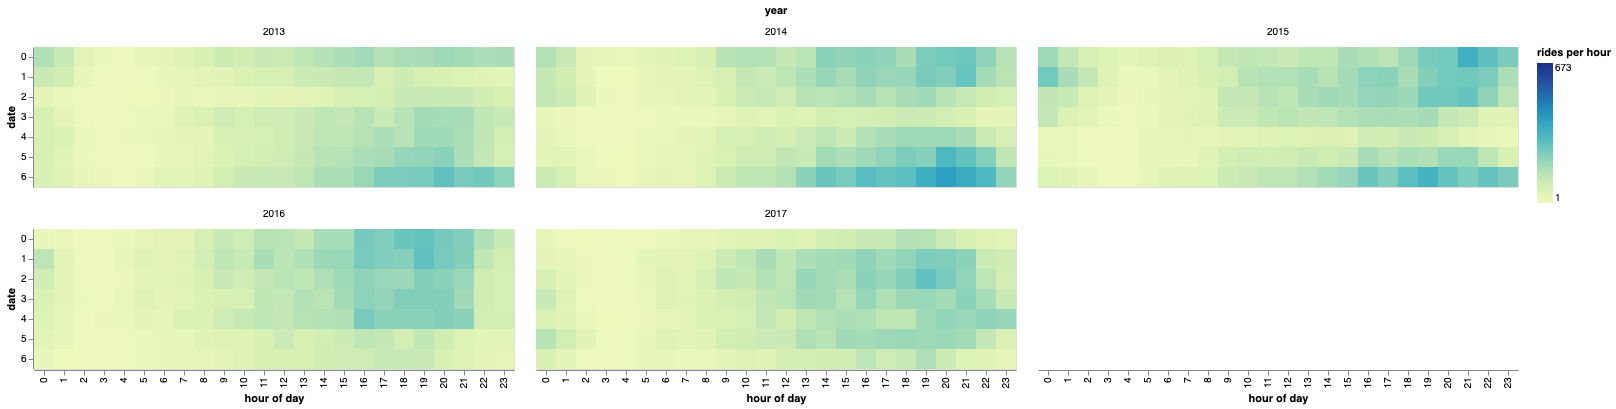

In [60]:
alt.Chart(ORD_train).mark_rect().encode(
    alt.X('hour:O', title='hour of day'),
    alt.Y('dayofweek:O', title='date'),
    alt.Color('rides:Q', title='rides per hour')
).facet(
    facet='year:N',
    columns=3
)

**Flights per day of the week**

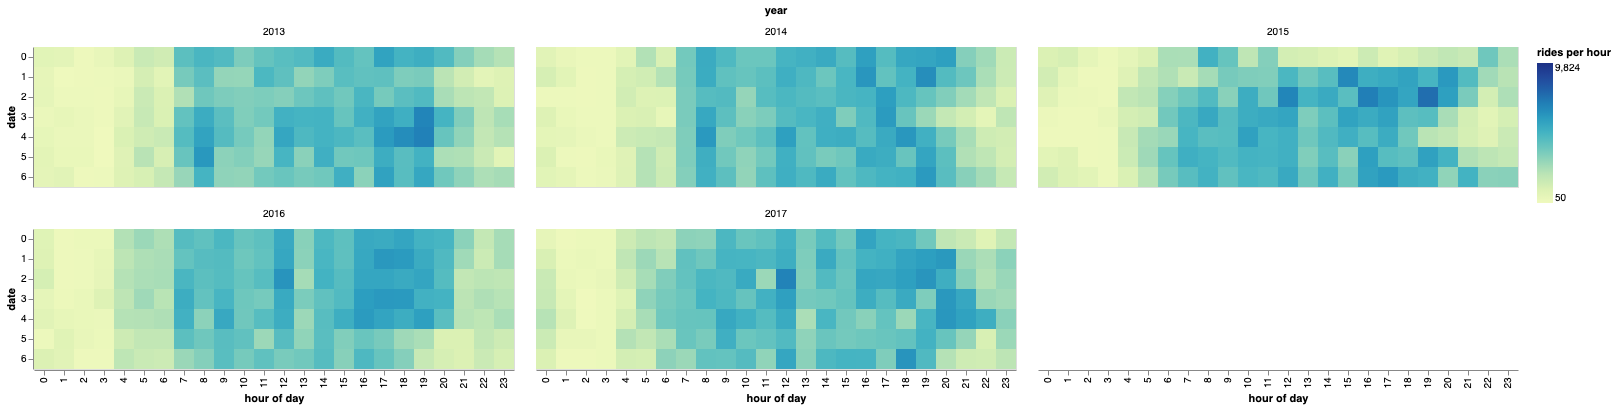

In [62]:

alt.Chart(ORD_train).mark_rect().encode(
    alt.X('hour:O', title='hour of day'),
    alt.Y('dayofweek:O', title='date'),
    alt.Color('seats:Q', title='rides per hour')
).facet(
    facet='year:N',
    columns=3
)

In [32]:

ORD_train['datetime']= ORD_train.apply(lambda x: datetime.datetime(int(x['year']),int(x['month']),int(x['day'])), axis=1)
# x = datetime.datetime(2020, 5, 17)

print(x)

2020-05-17 00:00:00


/Users/jaromeleslie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
ORD_train['dayofweek'] = pd.DatetimeIndex(ORD_train['datetime']).dayofweek

/Users/jaromeleslie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
map(datetime.dayofweek, ORD_train['datetime'])

AttributeError: module 'datetime' has no attribute 'dayofweek'

In [47]:
ORD_train['dayofweek'].unique()

array([1, 2, 3, 4, 5, 6, 0])

In [64]:
ORD_train.groupby(['year','month','day']).sum().reset_index()

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline,dayofweek
0,2013,1,1,276,1466,460.230,175.020000,1449.628333,204.666667,0.000100,235.666667,193.356667,57.333333,77418.063862,757.0,24
1,2013,1,2,276,1927,417.000,121.710000,1412.280000,152.000000,0.000000,240.000000,195.190000,30.500000,82622.897207,820.0,48
2,2013,1,3,272,1734,598.480,434.410000,1705.545000,221.500000,0.000800,198.000000,363.475000,98.000000,82918.243422,815.0,69
3,2013,1,4,276,1566,546.240,351.660000,1722.630000,285.000000,0.000000,239.000000,251.700000,7.000000,83589.268893,822.0,96
4,2013,1,5,273,1292,675.436,535.180000,1805.362667,171.200000,0.019600,190.133333,502.136000,38.000000,63094.646590,605.0,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017,12,27,276,3044,26.600,-219.700000,1475.870000,192.224359,0.000067,240.000000,-325.170000,2.769231,86518.508386,660.0,48
1822,2017,12,28,276,2727,156.075,-57.700000,1597.457500,123.524267,0.027220,203.896978,-68.915833,72.230769,85781.359497,653.0,72
1823,2017,12,29,276,2522,292.750,145.593333,1827.038333,154.757660,0.047421,145.718197,43.174333,99.457983,85633.542853,652.0,96
1824,2017,12,30,276,2641,205.250,-23.150000,1561.060000,267.941403,0.021000,197.182692,-171.965000,55.741758,72573.736486,565.0,120


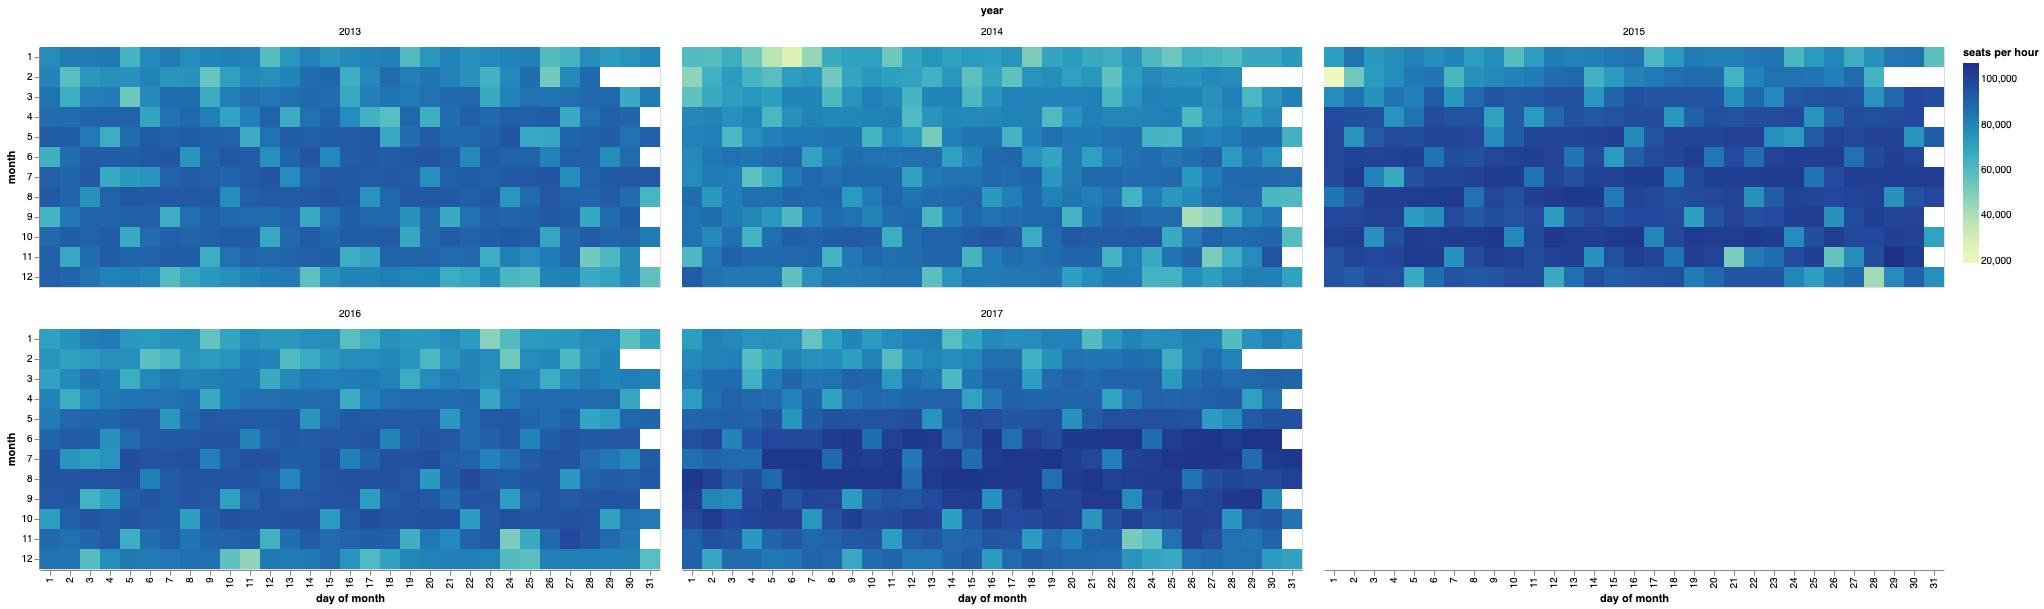

In [69]:

alt.Chart(ORD_train.groupby(['year','month','day']).sum().reset_index()).mark_rect().encode(
    alt.X('day:N', title='day of month'),
    alt.Y('month:O', title='month'),
    alt.Color('seats:Q', title='seats per hour')
).facet(
    facet='year:N',
    columns=3
)

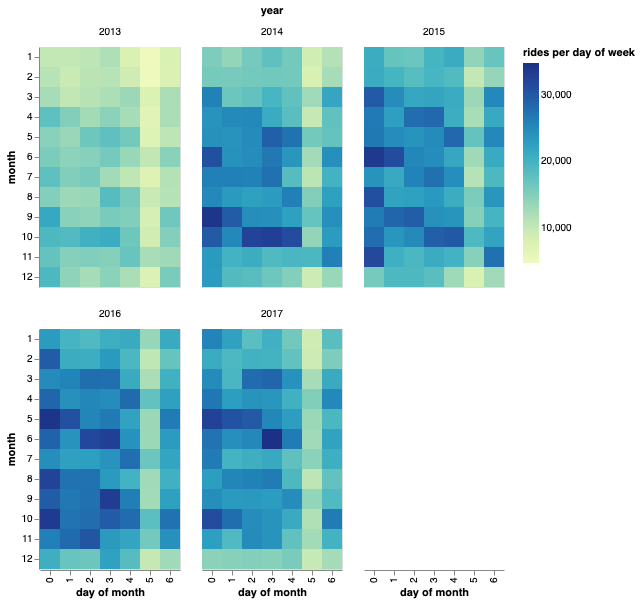

In [76]:

alt.Chart(ORD_train.groupby(['year','month','dayofweek']).sum().reset_index()).mark_rect().encode(
    alt.X('dayofweek:N', title='day of month'),
    alt.Y('month:O', title='month'),
    alt.Color('rides:Q', title='rides per day of week')
).facet(
    facet='year:N',
    columns=3
)

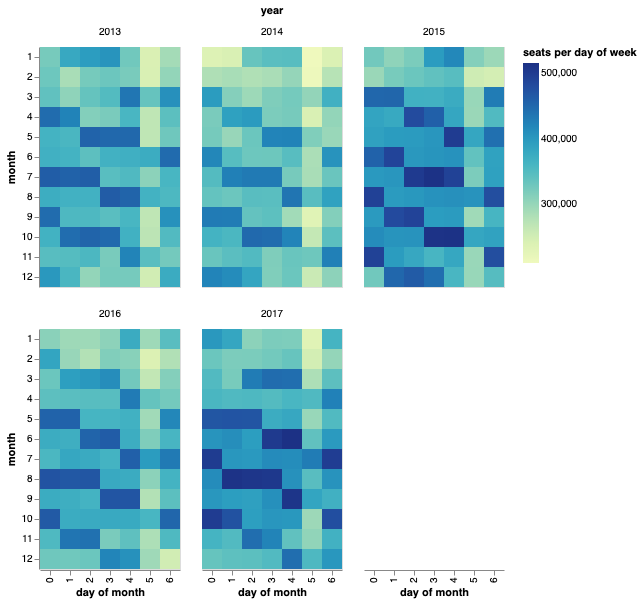

In [77]:

alt.Chart(ORD_train.groupby(['year','month','dayofweek']).sum().reset_index()).mark_rect().encode(
    alt.X('dayofweek:O', title='day of month'),
    alt.Y('month:O', title='month'),
    alt.Color('seats:Q', title='seats per day of week')
).facet(
    facet='year:N',
    columns=3
)

In [78]:
ORD_train

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline,datetime,dayofweek
0,2013,1,1,0,22,24.98,17.96,74.290000,9.000000,0.0,9.000000,14.780000,3.000000,547.597141,3.0,2013-01-01,1
1,2013,1,1,1,9,24.89,17.78,73.995000,9.000000,0.0,8.000000,14.670000,5.000000,148.479860,1.0,2013-01-01,1
2,2013,1,1,2,11,21.20,14.00,73.320000,10.000000,0.0,9.000000,9.420000,5.000000,NaN,NaN,2013-01-01,1
3,2013,1,1,3,3,21.14,12.14,67.723333,10.666667,0.0,9.666667,8.976667,4.333333,NaN,NaN,2013-01-01,1
4,2013,1,1,4,5,19.94,10.94,67.580000,10.000000,0.0,10.000000,7.840000,5.000000,860.523798,4.0,2013-01-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43757,2017,12,31,19,159,12.90,-2.00,50.620000,12.769231,0.0,10.000000,-3.460000,2.923077,4638.370834,37.0,2017-12-31,6
43758,2017,12,31,20,100,12.90,-2.90,48.500000,13.153846,0.0,10.000000,-2.900000,0.230769,2196.333217,15.0,2017-12-31,6
43759,2017,12,31,21,62,10.90,-4.00,50.280000,12.307692,0.0,10.000000,-5.460000,0.230769,1452.166804,10.0,2017-12-31,6
43760,2017,12,31,22,53,9.00,-4.00,54.740000,11.666667,0.0,10.000000,-5.090000,0.307692,1369.599078,9.0,2017-12-31,6
